In [2]:
import sys
import os
spr_path = "/Users/Dixit/Documents/Studies/CU_Boulder/sem3/Independent_study/code/SpringRank/python"
sys.path.append(os.path.abspath(spr_path))
import SpringRank_tools as SR
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import time
import pandas as pd
import math

In [3]:
import networkx as nx
import numpy as np
import SpringRank_tools as sr
import tools as tl

In [4]:
input_data_dir = '/Users/Dixit/Documents/Studies/CU_Boulder/sem3/Independent_study/github/SpringRank/data/input/'
output_data_dir = '/Users/Dixit/Documents/Studies/CU_Boulder/sem3/Independent_study/github/SpringRank/data/output/'

In [5]:
teamIdMap = {}
nextIdx = 0;

In [6]:
def getAdjByYear(year,nextIdx,teamIdMap):
    Adj = np.zeros((50,50),dtype=np.int)
    with open(input_data_dir+"NHL/"+str(year)+"_NHL",'r') as nhl:
        nhl = csv.reader(nhl,delimiter=',')
        for row in nhl:
            if row[1] not in teamIdMap:
                teamIdMap[row[1]] = nextIdx
                nextIdx+=1
            if row[2] not in teamIdMap:
                teamIdMap[row[2]] = nextIdx
                nextIdx+=1
            i = teamIdMap[row[1]]
            j = teamIdMap[row[2]]
            if Adj[(i,j)] == 0:
                Adj[(i,j)] = row[3]
            else:
                print("Duplicate? "+str(i)+" "+str(j)+" "+row[1]+" "+row[2])
    Adj = np.matrix(Adj,copy=False)
    return Adj,nextIdx,teamIdMap

In [7]:
Adj_2000,nextIdx,teamIdMap = getAdjByYear(2000,nextIdx,teamIdMap)
Adj_2001,nextIdx,teamIdMap = getAdjByYear(2001,nextIdx,teamIdMap)
Adj_2002,nextIdx,teamIdMap = getAdjByYear(2002,nextIdx,teamIdMap)
Adj_2003,nextIdx,teamIdMap = getAdjByYear(2003,nextIdx,teamIdMap)
Adj_2004,nextIdx,teamIdMap = getAdjByYear(2004,nextIdx,teamIdMap)
Adj_2005,nextIdx,teamIdMap = getAdjByYear(2005,nextIdx,teamIdMap)
Adj_2006,nextIdx,teamIdMap = getAdjByYear(2006,nextIdx,teamIdMap)
Adj_2007,nextIdx,teamIdMap = getAdjByYear(2007,nextIdx,teamIdMap)
Adj_2008,nextIdx,teamIdMap = getAdjByYear(2008,nextIdx,teamIdMap)
Adj_2009,nextIdx,teamIdMap = getAdjByYear(2009,nextIdx,teamIdMap)
Adj_2010,nextIdx,teamIdMap = getAdjByYear(2010,nextIdx,teamIdMap)
Adj_2011,nextIdx,teamIdMap = getAdjByYear(2011,nextIdx,teamIdMap)



In [8]:
len(teamIdMap)

32

In [9]:
teamIdMap

{'ANA': 0,
 'AND': 30,
 'ATL': 1,
 'BOS': 2,
 'BUF': 3,
 'CAL': 4,
 'CAR': 5,
 'CBS': 6,
 'CHI': 7,
 'COL': 8,
 'DAL': 9,
 'DET': 10,
 'EDM': 11,
 'FLO': 12,
 'LAK': 13,
 'MIN': 14,
 'MTL': 15,
 'NAS': 16,
 'NJD': 17,
 'NYI': 18,
 'NYR': 19,
 'OTT': 20,
 'PHI': 21,
 'PHO': 22,
 'PIT': 23,
 'SJS': 24,
 'STL': 25,
 'TBL': 26,
 'TOR': 27,
 'VAN': 28,
 'WAS': 29,
 'WPG': 31}

In [10]:
def run(A,alpha,l0,l1):
    '''
    Extracts SpringRank
    '''
    rank=sr.SpringRank(A,alpha=alpha,l0=l0,l1=l1)
    rank=tl.shift_rank(rank)   # (optional) shifts so that the min is in zero and the others are positive
    
    unordered_tuples=[(i,rank[i]) for i in range(A.shape[0])]
    return rank,unordered_tuples

def save(sorted_tuples,alpha,l0,l1,G,file):
    '''
    Prints results
    '''
    print('SpringRank scores:')
    outfile=output_data_dir+'/'+file+'_SpringRank_'+'a'+str(alpha)+'_l0_'+str(l0)+'_l1_'+str(l1)+'.dat'
    outf=open(outfile,'w')

    for i in range(G.number_of_nodes()):
        outf.write("{} {}\n".format(sorted_tuples[i][0],sorted_tuples[i][1]))
    print('Results saved in:', outfile)
    outf.close()
    


In [11]:
def getEqn39(rank,A,start,end,step):
    x = np.arange(start,end,step)
    y=[]
    for xi in x:
        y.append(tl.eqs39(xi,rank,A))
    return x,y

def eqn39SimplePlot(rank,A,save):
    x,y = getEqn39(rank,A,0.1,20,1)
    plt.plot(x,y)
    plt.title('Eqn 39 :'+save)
    if save:
        plt.savefig(output_data_dir+save+'.svg')

#prediction score for every pair or only for ones we 
def prediction(beta,Adj,scores):
    preds={}
    size=Adj.shape[0]
    for i in range(0,size):
        for j in range(0,size):
            if(Adj[(i,j)]>0 or Adj[(j,i)]>0):
                preds[(i,j)] = 1/(1+np.exp(-beta*2*(scores[i]-scores[j])))
            else: preds[(i,j)] = 0
    return preds

def getAccuracy(preds,Adj,num_edges):
    total=0
    size = Adj.shape[0]
    for i in range(0,size):
        for j in range(0,size):
            if(i!=j and (Adj[(i,j)]>0 or Adj[(j,i)]>0)):
                total += abs(Adj[(i,j)]-((Adj[(i,j)]+Adj[j,i])*preds[(i,j)]))
    total = 1-((total)/(2*num_edges))
    return total

 


In [12]:
def expectedEqn(beta,c,si,sj):
    return c*np.exp(-beta*0.5*(si-sj-1)*(si-sj-1))

def getC(beta,num_nodes,scores):
    c = 20*num_nodes
    total = 0;
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            total+=np.exp(-beta*0.5*(scores[i]-scores[j]-1)*(scores[i]-scores[j]-1))
    return c*1.0/(total)

def createNetwork(scores,beta,c,num_nodes):
    A = np.zeros((num_nodes,num_nodes),dtype=np.int)
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if(i!=j):
                mean = expectedEqn(beta,c,scores[i],scores[j])
                weight = np.random.poisson(mean)
                A[i,j] = weight
    return A

def generateNetwork(beta):
    number_of_nodes=100
    mu, sigma = 0.5,1 # mean and standard deviation
    #np.random.seed(int(time.time()))
    scores = np.random.normal(mu, sigma, number_of_nodes+1)
    c=getC(beta,number_of_nodes,scores)
    A = createNetwork(scores,beta,c,number_of_nodes)
    A = np.matrix(A,copy=False)
    return A,scores

def getEdgeList(A):
    edge_list = []
    shape,_=A.shape
    for i in range(0,shape):
        for j in range(0,shape):
            edge_list.append((i,j))
    return edge_list
        
    
# remove interaction, regardless of weight
def getTrainingandTestSet(A_orig):
    A_train = A_orig.copy()
    A_test  = np.zeros((A_orig.shape),dtype=np.int)
    edge_list = getEdgeList(A_orig)
    np.random.shuffle(edge_list)
    choice_idx = np.random.choice(len(edge_list), int(len(edge_list)*0.2), replace=False)
    for i in choice_idx:
        (k,l) = edge_list[i]
        A_test[(k,l)] = A_orig[(k,l)]
        A_train[(k,l)] = 0
    A_train = np.matrix(A_train,copy=False)
    A_test = np.matrix(A_test,copy=False)    
    return A_train,A_test

def trainBetaAndRanks(A,alpha,l0,l1):
    ranks,tuples = run(A,alpha,l0,l1)
    temp=tl.get_optimal_temperature(ranks,A)
    beta = 1/temp
    print("Optimal Beta: "+str(beta))
    return beta,ranks

def getPredictionsAndAccuracy(beta,A,ranks):
    preds = prediction(beta,A,ranks)
    acc = getAccuracy(preds,A,A.sum())
    print("Accuracy : "+str(acc))
    return preds,acc


    

In [13]:
Adj_All = [Adj_2000,Adj_2001,Adj_2002,Adj_2003,Adj_2004,Adj_2005,Adj_2006,Adj_2007,Adj_2008,Adj_2009,Adj_2010,Adj_2011]
Adj_years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']

In [207]:
def trainForward(Adj_All,Adj_years):
    accu_map = {}
    accu_list = []
    for i in range(0,len(Adj_All)-1):
        print(Adj_years[i]+" "+Adj_years[i+1])
        A1 = Adj_All[i]
        A2 = Adj_All[i+1]
        A1_beta,A1_ranks,A1_preds,A1_acc = trainingExperiment(A1,0,0,1)
        A12_preds,A12_acc = getPredictionsAndAccuracy(A1_beta,A2,A1_ranks)
        accu_map[Adj_years[i]] = (A1_acc,A12_acc)
        accu_list.append(A12_acc)
    return accu_map,accu_list

        
        

In [ ]:
def trainOneToMany(indexToTrain,Adj_All,Adj_years):
    accu_map = {}
    accu_list = []
    for i in range(0,len(Adj_All)-1):
        print(Adj_years[i]+" "+Adj_years[i+1])
        A1 = Adj_All[i]
        A2 = Adj_All[i+1]
        A1_beta,A1_ranks,A1_preds,A1_acc = trainingExperiment(A1,0,0,1)
        A12_preds,A12_acc = getPredictionsAndAccuracy(A1_beta,A2,A1_ranks)
        accu_map[Adj_years[i]] = (A1_acc,A12_acc)
        accu_list.append(A12_acc)
    return accu_map,accu_list

        
        

In [208]:
accu_map,accu_list = trainForward(Adj_All,Adj_years)

2000 2001
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.744592012006
2001 2002
Optimal Beta: 1.1762913609744081
Accuracy : 0.771437047888
Accuracy : 0.731678262885
2002 2003
Optimal Beta: 1.128530104071782
Accuracy : 0.768853152412
Accuracy : 0.746891801255
2003 2004
Optimal Beta: 1.0623365168732528
Accuracy : 0.782065048215
Accuracy : nan
2004 2005
Optimal Beta: 100.0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in long_scalars


Accuracy : nan
Accuracy : 0.760162601626
2005 2006
Optimal Beta: 1.0485941123868026
Accuracy : 0.795448644283
Accuracy : 0.767638689513
2006 2007
Optimal Beta: 1.0321139618432638
Accuracy : 0.804175679747
Accuracy : 0.77603037857
2007 2008
Optimal Beta: 1.151481211308581
Accuracy : 0.798568390179
Accuracy : 0.755143288
2008 2009
Optimal Beta: 1.1601591219543912
Accuracy : 0.768419019834
Accuracy : 0.752266832084
2009 2010
Optimal Beta: 1.092889308445037
Accuracy : 0.777724296592
Accuracy : 0.753502069544
2010 2011
Optimal Beta: 1.101169337972811
Accuracy : 0.771614325459
Accuracy : 0.76102445785


In [177]:
(accu_map)

{'2000': (0.77485054698781686, 0.74459201200562086),
 '2001': (0.77143704788758283, 0.73167826288540083),
 '2002': (0.76885315241163277, 0.7468918012552197),
 '2003': (0.78206504821478373, nan),
 '2004': (nan, 0.76016260162601623),
 '2005': (0.79544864428260253, 0.76763868951261227),
 '2006': (0.80417567974705384, 0.77603037857041002),
 '2007': (0.79856839017886849, 0.75514328800020469),
 '2008': (0.76841901983406324, 0.75226683208387746),
 '2009': (0.77772429659168751, 0.75350206954432808),
 '2010': (0.77161432545884812, 0.76102445784976713)}

In [178]:
accu_list

[0.74459201200562086,
 0.73167826288540083,
 0.7468918012552197,
 nan,
 0.76016260162601623,
 0.76763868951261227,
 0.77603037857041002,
 0.75514328800020469,
 0.75226683208387746,
 0.75350206954432808,
 0.76102445784976713]

In [199]:
? plt.subplot

In [209]:
def plotYOYAccuracy(Adj_years,accu_map):
    training_acc = []
    predic_acc = []
    x_axis = []
    for i in range(0,len(Adj_years)-1):
        (t,p) = accu_map[Adj_years[i]]
        training_acc.append(t)
        predic_acc.append(p)
        x_axis.append(Adj_years[i])
    
    plt.xlabel('Years')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])
    

    plt.plot(x_axis,training_acc,'b--',label='training accuracy')
    plt.plot(x_axis,predic_acc,'r--',label='prediction accuracy')
    plt.legend(loc='best')
    plt.show()

In [201]:
Adj_years

['2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011']

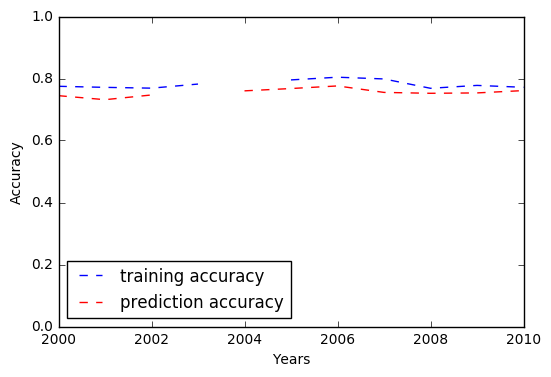

In [210]:
plotYOYAccuracy(Adj_years,accu_map)

# Create networks 1,2,3 ; Create training and test sets

In [203]:
def experimentBeta(beta):
    A1,scores1 = generateNetwork(beta=beta) # Adjacency Network A
    A2,scores2 = generateNetwork(beta=beta) # Adjacency Network B
    A3,scores3 = generateNetwork(beta=beta) # Adjacency Network C
    A1_train,A1_test = getTrainingandTestSet(A1)
    A3_train,A3_test = getTrainingandTestSet(A3)
    A13 = np.add(A1,A3)
    A13_train,A13_test = getTrainingandTestSet(A13)
    graphProp(A1,"Network A")
    graphProp(A1_train,"NetworkA Training")
    graphProp(A1_test,"NetworkA Test")
    graphProp(A2,"Network B")
    graphProp(A3,"NetworkC")
    graphProp(A13,"Network A+C")
    
    # =================== Experiment 1  (A --> B) ===================
    A1_beta_train,A1_ranks_train,A1_preds_train,A1_acc_train = trainingExperiment(A1_train,0,0,1)
    A1_preds_test,A1_acc_test = getPredictionsAndAccuracy(A1_beta_train,A1_test,A1_ranks_train)
    A12_preds,A12_acc = getPredictionsAndAccuracy(A1_beta_train,A2,A1_ranks_train)
    
    # =================== Experiment 2 (C --> B) ===================
    A3_beta_train,A3_ranks_train,A3_preds_train,A3_acc_train = trainingExperiment(A3_train,0,0,1)
    A3_preds_test,A3_acc_test = getPredictionsAndAccuracy(A3_beta_train,A3_test,A3_ranks_train)
    A32_preds,A32_acc = getPredictionsAndAccuracy(A3_beta_train,A2,A3_ranks_train)

    # =================== Experiment 3 (A+C --> B) ===================
    A13_beta_train,A13_ranks_train,A13_preds_train,A13_acc_train = trainingExperiment(A13_train,0,0,1)
    A13_preds_test,A13_acc_test = getPredictionsAndAccuracy(A13_beta_train,A13_test,A13_ranks_train)
    A132_preds,A132_acc = getPredictionsAndAccuracy(A13_beta_train,A2,A13_ranks_train)

    experiment_names = ["Experiment 1 (A-->B)","Experiment 2 (C-->B)","Experiment 3 (A+C-->B)"]
    experiments = [[A1_acc_train,A1_acc_test,A12_acc],[A3_acc_train,A3_acc_test,A32_acc],[A13_acc_train,A13_acc_test,A132_acc]]
    data = np.array([
        ['','Training data (80%)','Test data (20%)','Network B (100%)'],
        [experiment_names[0],A1_acc_train,A1_acc_test,A12_acc],
        [experiment_names[1],A3_acc_train,A3_acc_test,A32_acc],
        [experiment_names[2],A13_acc_train,A13_acc_test,A132_acc]])
    dataframe  = pd.DataFrame(data=data[1:,1:],
                         index=data[1:,0],
                         columns=data[0,1:])
    return dataframe


In [204]:
pd.concat(df)

NameError: name 'df' is not defined

In [38]:
def trainingExperiment(A,alpha,l0,l1):
    beta,ranks = trainBetaAndRanks(A,alpha,l0,l1)
    preds,acc =  getPredictionsAndAccuracy(beta,A,ranks)
    return beta,ranks,preds,acc


# =================== Experiment 2000 --> 2001  ===================


## Learn Adj_2000

In [39]:
Adj_2000_beta_train,Adj_2000_ranks_train,Adj_2000_preds_train,Adj_2000_acc_train = trainingExperiment(Adj_2000,0,0,1)

Optimal Beta: 1.1260979122490353
Accuracy : 0.676575439511


## Predict Adj_2001 using Adj_2000

In [43]:
Adj_0001_preds,Adj_0001_acc = getPredictionsAndAccuracy(Adj_2000_beta_train,Adj_2001,Adj_2000_ranks_train)


Accuracy : 0.629341403263


# =================== Experiment 2 (C --> B) ===================

## Learn Adj_2002

In [42]:
Adj_2002_beta_train,Adj_2002_ranks_train,Adj_2002_preds_train,Adj_2002_acc_train = trainingExperiment(Adj_2002,0,0,1)

Optimal Beta: 1.128530104071782
Accuracy : 0.674028850997


## Predict Adj_2001 using Adj_2002

In [44]:
Adj_0201_preds,Adj_0201_acc = getPredictionsAndAccuracy(Adj_2002_beta_train,Adj_2001,Adj_2002_ranks_train)


Accuracy : 0.61627773899


# =================== Experiment 3 (A+C --> B) ===================

## Learn A_C_80%

In [223]:
A13_beta_train,A13_ranks_train,A13_preds_train,A13_acc_train = trainingExperiment(A13_train,0,0,1)

Optimal Beta: 0.9526270452662132
Accuracy : 0.62393456557


## Predict A_C_20% using A_C_80% parameters


In [224]:
graphProp(A13,"")


 no. of nodes= 100, no. of edges= 3984


In [225]:
A13_preds_test,A13_acc_test = getPredictionsAndAccuracy(A13_beta_train,A13_test,A13_ranks_train)


Accuracy : 0.55586105379


## Predict B_100% using A_C_80%

In [226]:
A132_preds,A132_acc = getPredictionsAndAccuracy(A13_beta_train,A2,A13_ranks_train)


Accuracy : 0.536280737703


In [227]:
experiment_names = ["Experiment 1 (A-->B)","Experiment 2 (C-->B)","Experiment 3 (A+C-->B)"]
experiments = [[A1_acc_train,A1_acc_test,A12_acc],[A3_acc_train,A3_acc_test,A32_acc],[A13_acc_train,A13_acc_test,A132_acc]]

In [228]:
data = np.array([
        ['','Training data (80%)','Test data (20%)','Network B (100%)'],
        [experiment_names[0],A1_acc_train,A1_acc_test,A12_acc],
        [experiment_names[1],A3_acc_train,A3_acc_test,A32_acc],
        [experiment_names[2],A13_acc_train,A13_acc_test,A132_acc]])
dataframe  = pd.DataFrame(data=data[1:,1:],
                         index=data[1:,0],
                         columns=data[0,1:])
print(dataframe)

                       Training data (80%) Test data (20%) Network B (100%)
Experiment 1 (A-->B)        0.645085594569  0.627621256663   0.538836368368
Experiment 2 (C-->B)        0.646895028609  0.623727437717   0.500678374398
Experiment 3 (A+C-->B)       0.62393456557   0.55586105379   0.536280737703


# Train 100%

# Trying a small graph. Things we discussed during the meeting

In [195]:
#create  a toy graph
G_small = nx.MultiDiGraph()
G_small.add_edge(0,1)
G_small.add_edge(0,1)
G_small.add_edge(1,0)

0

In [196]:
G_small.edges

OutMultiEdgeView([(0, 1, 0), (0, 1, 1), (1, 0, 0)])

In [197]:
# learn ranks and get optimal temperature 
A1_small = nx.to_numpy_matrix(G_small,nodelist=list(G_small.nodes))
A1_beta_small,A1_ranks_small = trainBetaAndRanks(A1_small,0,0,1)
A1_preds_small,A1_acc_small = getPredictionsAndAccuracy(A1_beta_small,A1_small,A1_ranks_small)

Optimal Beta: 1.9235933878519509
Accuracy : 0.476211459833


In [199]:
(A1_small+A1_small).sum()

6.0

In [552]:
A1_preds_small

{(0, 0): 0,
 (0, 1): 0.92856093675019202,
 (1, 0): 0.071439063249808032,
 (1, 1): 0}

In [553]:
beta_a = np.log(2)*3/4

In [554]:
1/(1+np.exp(-4/3*beta_a))

0.66666666666666663

In [555]:
rank1_small

array([ 0.66666667,  0.        ])

In [265]:
G_small.edges

OutMultiEdgeView([(0, 1, 0), (0, 1, 1), (1, 0, 0)])

In [266]:
beta_a

0.51986038541995894

#  Chess matches. TODO beyond this point


In [79]:
G_chess = getMultiDiGraphFromFile(input_data_dir+"formatted_chess_edgelist.data")



In [27]:
G_chess_train,G_chess_test = getTrainingandTestSet(G_chess)
A_chess_test = nx.to_numpy_matrix(G_chess_test,nodelist=list(G_chess_test.nodes),weight='weight')

In [785]:
graphProp(G_chess)
graphProp(G_chess_train)

no. of nodes= 6832, no. of edges= 36387
no. of nodes= 6832, no. of edges= 29110


In [786]:
alpha,l0,l1=0,0,1
rank_chess_train,tuples_chess = run(G_chess_train,alpha,l0,l1)

A_chess_train = nx.to_numpy_matrix(G_chess_train,nodelist=list(G_chess_train.nodes),weight='weight')

#get opt beta
#temp_chess_train=tl.get_optimal_temperature(rank_chess_train,A_chess_train)
#beta_chess_train = 1/temp_chess_train
print((beta_chess_train))


0.6180489072195094


In [80]:
A_chess = nx.to_numpy_matrix(G_chess)


In [81]:
G_chess.number_of_edges(3106,2307)

5

In [ ]:
A_chess

In [ ]:
1.